# **1.Installations**

In [1]:
#Install dependencies
!pip install --upgrade pip
!pip install diffusers transformers accelerate peft safetensors ftfy pillow numpy matplotlib tqdm opencv-python scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 77.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [2]:
# Mounting google drive for data
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [8]:
#Importing all the neccessary libraries
import os, cv2
import numpy as np
import random
from pathlib import Path
from PIL import Image, ImageFilter, ImageEnhance, ImageDraw
from tqdm import tqdm
import torch

# Change this paths to match your drive
RAW_DIR = Path("/content/drive/MyDrive/Photo Restoration/Raw Images") # original raw images
CLEAN_DIR   = Path("/content/drive/MyDrive/Photo Restoration/train/clean images") # preprocessed clean images
DAMAGED_DIR = Path("/content/drive/MyDrive/Photo Restoration/train/damaged images") # real damaged images
SYN_DAM_DIR  = Path("/content/drive/MyDrive/Photo Restoration/sync damaged images") # synthetic damaged images
MASK_DIR    = Path("/content/drive/MyDrive/Photo Restoration/train/mask") # mask outputs

os.makedirs(RAW_DIR, exist_ok=True)
os.makedirs(CLEAN_DIR, exist_ok=True)
os.makedirs(DAMAGED_DIR, exist_ok=True)
os.makedirs(SYN_DAM_DIR, exist_ok=True)
os.makedirs(MASK_DIR, exist_ok=True)

# **2.Preprocessing**

In [11]:
# image size and training settings
IMAGE_SIZE = 512               # 512 x 512 (For Stable Diffusion)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 1                 # small for Colab T4
EPOCHS = 5                     # change upward for longer training
LR = 1e-5
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

In [19]:
# Center cropping image to square
def center_crop(img: Image.Image) -> Image.Image:
    width, height = img.size
    crop_size = min(width, height)
    left = (width - crop_size) // 2
    top = (height - crop_size) // 2
    right = left + crop_size
    bottom = top + crop_size
    return img.crop((left, top, right, bottom))

# Applying histogram equalization to normalize contrast
def normalize_color(img: Image.Image) -> Image.Image:
    img_cv = np.array(img)
    img_yuv = cv2.cvtColor(img_cv, cv2.COLOR_RGB2YUV)
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
    img_norm = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    return Image.fromarray(img_norm)

# Removing EXIF metadata by resaving pixel data into a new Image object
def remove_metadata(img: Image.Image) -> Image.Image:
    data = list(img.getdata())
    new_img = Image.new(img.mode, img.size)
    new_img.putdata(data)
    return new_img

# Processing raw images folder to clean images folder
from pathlib import Path # Ensure Path is imported
RAW_DIR = Path(RAW_DIR) # Convert to Path object
CLEAN_DIR = Path(CLEAN_DIR) # Convert to Path object

if RAW_DIR.exists():
    print("Preprocessing raw images from:", RAW_DIR)
    for filename in sorted(os.listdir(RAW_DIR)):
        if not filename.lower().endswith((".png", ".jpg", ".jpeg")):
            continue
        in_path = RAW_DIR / filename
        out_name = Path(filename).stem + ".png"
        out_path = CLEAN_DIR / out_name
        try:
            img = Image.open(in_path).convert("RGB")
            img = center_crop(img)
            img = img.resize((IMAGE_SIZE, IMAGE_SIZE), Image.LANCZOS)
            img = normalize_color(img)
            img = remove_metadata(img)
            img.save(out_path, format="PNG")
        except Exception as e:
            print("Error processing", filename, ":", e)
    print("Preprocessing complete. Clean images saved to:", CLEAN_DIR)
else:
    print("Raw folder not found; skipping preprocessing. Ensure CLEAN_DIR contains your clean images.")

# Ensuring DAMAGED_DIR images are PNG and sized correctly.
DAMAGED_DIR = Path(DAMAGED_DIR) # Convert to Path object
for fname in tqdm(sorted(os.listdir(DAMAGED_DIR))): # Fixed DAMAGED_DIR_DIR to DAMAGED_DIR
    p = DAMAGED_DIR / fname
    try:
        img = Image.open(p).convert("RGB")
        if img.size != (IMAGE_SIZE, IMAGE_SIZE) or p.suffix.lower() != ".png":
            img = center_crop(img).resize((IMAGE_SIZE, IMAGE_SIZE), Image.LANCZOS)
            img = normalize_color(img)
            img = remove_metadata(img)
            out_name = Path(p).stem + ".png"
            img.save(DAMAGED_DIR / out_name, format="PNG")
            if p.suffix.lower() != ".png":
                p.unlink(missing_ok=True)
    except Exception as e:
        print("Skipping:", p, e)

Preprocessing raw images from: /content/drive/MyDrive/Photo Restoration/Raw Images
Preprocessing complete. Clean images saved to: /content/drive/MyDrive/Photo Restoration/train/clean images


100%|██████████| 109/109 [00:41<00:00,  2.60it/s]


# **3.Damaging the Image**

In [21]:
# Sepia tone, matrix multiply and clip
def apply_sepia(arr: np.ndarray) -> np.ndarray:
    filt = np.array([[0.393, 0.769, 0.189],
                     [0.349, 0.686, 0.168],
                     [0.272, 0.534, 0.131]])
    out = arr @ filt.T
    return np.clip(out, 0, 255)

# Draw semi-transparent wavy crease lines
def add_cracks(arr: np.ndarray, num_cracks=3) -> np.ndarray:
    h, w = arr.shape[:2]
    img = Image.fromarray(arr.astype(np.uint8))
    draw = ImageDraw.Draw(img, "RGBA")
    for _ in range(num_cracks):
        x = random.randint(0, w-1); y = random.randint(0, h-1)
        angle = random.uniform(0, 7 * np.pi)
        length = random.randint(50, 150)
        points = [(x, y)]
        for _ in range(15):
            angle += random.uniform(-0.4, 0.4)
            step_len = length / 15.0
            x += step_len * np.cos(angle)
            y += step_len * np.sin(angle)
            points.append((int(x), int(y)))
            if random.random() > 0.7:
                # small branch
                branch_angle = angle + random.uniform(-1, 1)
                branch_len = random.randint(10, 30)
                bx = x + branch_len * np.cos(branch_angle)
                by = y + branch_len * np.sin(branch_angle)
                a = random.randint(100, 180)
                draw.line([(int(x), int(y)), (int(bx), int(by))], fill=(255,255,255,a), width=1)
        a_main = random.randint(120, 200)
        for i in range(len(points) - 1):
            draw.line([points[i], points[i+1]], fill=(255,255,255,a_main), width=2)
    return np.array(img).astype(np.float32)

# Create torn/irregular edges by masking and blending to a paper color
def add_torn_edges(arr: np.ndarray, intensity=40) -> np.ndarray:
    h, w = arr.shape[:2]
    img = Image.fromarray(arr.astype(np.uint8))
    mask = Image.new("L", (w, h), 255)
    draw = ImageDraw.Draw(mask)
    edges = random.sample(['top','bottom','left','right'], k=random.randint(1,2))
    for edge in edges:
        if edge == "top":
            for x in range(0, w, 8):
                depth = random.randint(0, intensity)
                width_e = random.randint(10, 30)
                draw.ellipse([x-width_e//2, -depth, x+width_e//2, depth], fill=0)
        elif edge == "bottom":
            for x in range(0, w, 8):
                depth = random.randint(0, intensity)
                width_e = random.randint(10, 30)
                draw.ellipse([x-width_e//2, h-depth, x+width_e//2, h+depth], fill=0)
        elif edge == "left":
            for y in range(0, h, 8):
                depth = random.randint(0, intensity)
                width_e = random.randint(10, 30)
                draw.ellipse([-depth, y-width_e//2, depth, y+width_e//2], fill=0)
        else:  # right
            for y in range(0, h, 8):
                depth = random.randint(0, intensity)
                width_e = random.randint(10, 30)
                draw.ellipse([w-depth, y-width_e//2, w+depth, y+width_e//2], fill=0)
    mask = mask.filter(ImageFilter.GaussianBlur(10))
    mask_arr = np.array(mask).astype(np.float32) / 255.0
    mask_3 = np.stack([mask_arr]*3, axis=2)
    paper = np.array([235, 230, 215], dtype=np.float32)
    result = arr * mask_3 + paper * (1 - mask_3)
    return result

# Add blurred semi-transparent circular stains
def add_stains(arr: np.ndarray, num_stains=10) -> np.ndarray:
    h, w = arr.shape[:2]
    img = Image.fromarray(arr.astype(np.uint8))
    for _ in range(num_stains):
        x = random.randint(0, w-1); y = random.randint(0, h-1)
        r = random.randint(15, 60)
        stain = Image.new("RGBA", (w, h), (0, 0, 0, 0))
        d = ImageDraw.Draw(stain)
        color_val = random.randint(100, 150)
        alpha = random.randint(20, 60)
        d.ellipse([x-r, y-r, x+r, y+r], fill=(color_val, color_val, color_val, alpha))
        stain = stain.filter(ImageFilter.GaussianBlur(15))
        img = Image.alpha_composite(img.convert("RGBA"), stain)
    return np.array(img.convert("RGB")).astype(np.float32)

# Multiply image by a subtle radial vignette to simulate aged edges
def add_vignette(arr: np.ndarray, intensity=0.35) -> np.ndarray:
    h, w = arr.shape[:2]
    X, Y = np.meshgrid(np.linspace(-1, 1, w), np.linspace(-1, 1, h))
    radius = np.sqrt(X**2 + Y**2)
    vign = 1 - intensity * np.clip(radius, 0, 1)
    vign_3 = np.stack([vign]*3, axis=2)
    return arr * vign_3

# Now apply the pipeline to all cleaned images and save to SYN_DAM_DIR as PNG
print("Generating synthetic damaged images from CLEAN_DIR -> SYN_DAM_DIR")
for fname in tqdm(sorted(os.listdir(CLEAN_DIR))):
    if not fname.lower().endswith(".png"):
        # we only expect PNG in CLEAN_DIR but handle others
        pass
    in_path = CLEAN_DIR / fname
    out_path = SYN_DAM_DIR / fname  # keep same name, PNG enforced
    try:
        img = Image.open(in_path).convert("RGB")
        arr = np.array(img).astype(np.float32)
        arr = apply_sepia(arr)
        arr = add_vignette(arr)
        arr = add_stains(arr, num_stains=random.randint(6,12))
        arr = add_cracks(arr, num_cracks=random.randint(2,4))
        arr = add_torn_edges(arr, intensity=random.randint(25,45))
        arr = np.clip(arr, 0, 255).astype(np.uint8)
        pil = Image.fromarray(arr)
        pil = pil.filter(ImageFilter.GaussianBlur(0.5))
        pil = ImageEnhance.Contrast(pil).enhance(0.9)
        # Save as PNG (consistent format)
        pil.save(out_path.with_suffix(".png"), format="PNG")
    except Exception as e:
        print("Failed:", in_path, e)
print("Synthetic damaged dataset created.")


# Auto-generate damage masks from SYN_DAM_DIR
def generate_damage_mask(img_pil: Image.Image) -> np.ndarray:
    """Return an 8-bit mask numpy array (0..255) marking damage regions."""
    img = np.array(img_pil)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l = lab[:,:,0]

    # high-pass for cracks
    hp = cv2.Laplacian(l, cv2.CV_8U, ksize=3)
    hp = cv2.normalize(hp, None, 0, 255, cv2.NORM_MINMAX)
    _, crack_bin = cv2.threshold(hp, 10, 255, cv2.THRESH_BINARY)

    # paint loss detection (bright)
    _, paint_loss = cv2.threshold(l, 215, 255, cv2.THRESH_BINARY)
    raw = cv2.bitwise_or(crack_bin, paint_loss)
    kernel = np.ones((3,3), np.uint8)
    raw = cv2.morphologyEx(raw, cv2.MORPH_OPEN, kernel, iterations=1)
    raw = cv2.dilate(raw, kernel, iterations=1)

    # area filtering
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(raw, connectivity=8)
    filtered = np.zeros_like(raw)
    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        if 50 < area < 25000:
            filtered[labels == i] = 255
    mask_soft = cv2.GaussianBlur(filtered, (21,21), 0)
    return mask_soft

# Create masks for synthetic dataset
def batch_create_masks(src_dir: Path, mask_out_dir: Path):
    mask_out_dir.mkdir(parents=True, exist_ok=True)
    for fname in tqdm(sorted(os.listdir(src_dir))):
        if not fname.lower().endswith((".png", ".jpg", ".jpeg")):
            continue
        img = Image.open(src_dir / fname).convert("RGB").resize((IMAGE_SIZE, IMAGE_SIZE))
        mask_np = generate_damage_mask(img)
        mask_pil = Image.fromarray(mask_np).convert("L")
        mask_pil.save(mask_out_dir / Path(fname).with_suffix(".png").name, format="PNG")

print("Generating masks for synthetic damaged images...")
SYN_DAM_DIR = Path(SYN_DAM_DIR)
MASK_DIR = Path(MASK_DIR)
batch_create_masks(SYN_DAM_DIR, MASK_DIR)

Generating synthetic damaged images from CLEAN_DIR -> SYN_DAM_DIR


100%|██████████| 109/109 [00:27<00:00,  3.95it/s]


Synthetic damaged dataset created.
Generating masks for synthetic damaged images...


100%|██████████| 109/109 [00:04<00:00, 22.53it/s]


In [22]:
# Auto crack and Damage mask generator
def generate_damage_mask(img_pil):
    img = np.array(img_pil)

    # 1. Convert to LAB (great for paint loss & contrast)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    # 2. High-pass filter for cracks
    hp = cv2.Laplacian(l, cv2.CV_8U, ksize=3)
    hp = cv2.normalize(hp, None, 0, 255, cv2.NORM_MINMAX)

    # 3. Threshold cracks
    _, crack_bin = cv2.threshold(hp, 10, 255, cv2.THRESH_BINARY)

    # 4. Paint loss detection (bright regions)
    _, paint_loss = cv2.threshold(l, 215, 255, cv2.THRESH_BINARY)

    # 5. Combine both
    raw_mask = cv2.bitwise_or(crack_bin, paint_loss)

    # 6. Clean noise
    kernel = np.ones((3,3), np.uint8)
    raw_mask = cv2.morphologyEx(raw_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    raw_mask = cv2.dilate(raw_mask, kernel, iterations=1)

    # 7. Area filtering (removes dust, keeps cracks)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(raw_mask, connectivity=8)

    filtered = np.zeros_like(raw_mask)
    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        if 50 < area < 25000:
            filtered[labels == i] = 255

    # 8. Soft museum-grade feathering
    mask_soft = cv2.GaussianBlur(filtered, (21,21), 0)

    return mask_soft

#Batch process all damaged images
for fname in tqdm(sorted(os.listdir(DAMAGED_DIR))):

    if not fname.lower().endswith((".png", ".jpg", ".jpeg")):
        continue

    damaged_path = os.path.join(DAMAGED_DIR, fname)
    img_pil = Image.open(damaged_path).convert("RGB")

    mask_np = generate_damage_mask(img_pil)
    mask_pil = Image.fromarray(mask_np).convert("L")

    save_path = os.path.join(MASK_DIR, fname)
    mask_pil.save(save_path)

print("All damage masks successfully created!")

 95%|█████████▌| 104/109 [00:05<00:00, 20.11it/s]/usr/local/lib/python3.12/dist-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `__iter__` directly via 'StableDiffusionInpaintPipeline' object attribute is deprecated. Please access '__iter__' over 'StableDiffusionInpaintPipeline's config object instead, e.g. 'scheduler.config.__iter__'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
100%|██████████| 109/109 [00:05<00:00, 20.11it/s]

All damage masks successfully created!


# **4.Training Diffusion Model using LoRa**

In [23]:
from diffusers import StableDiffusionInpaintPipeline, DDPMScheduler

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

#Loading stable diffusion inpaint model
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    torch_dtype=torch.float32).to(DEVICE)

pipe.scheduler = DDPMScheduler.from_pretrained(
    "runwayml/stable-diffusion-inpainting", subfolder="scheduler")

pipe.safety_checker = None
pipe.requires_safety_checker = False
pipe.enable_attention_slicing()
pipe.enable_vae_slicing()

pipe.vae.eval()
pipe.text_encoder.eval()

print("pipe recreated successfully")
print("Clean FP32 base model ready")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


pipe recreated successfully
Clean FP32 base model ready


In [24]:
from peft import LoraConfig, get_peft_model

#Attach LoRa Adapters to UNet
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["to_q","to_k","to_v","to_out.0"],
    lora_dropout=0.05,
    bias="none")

pipe.unet = get_peft_model(pipe.unet, lora_config)
pipe.unet.print_trainable_parameters()

print("Fresh LoRA attached")

trainable params: 3,188,736 || all params: 862,724,100 || trainable%: 0.3696
Fresh LoRA attached


In [25]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

BASE_TRAIN_PATH = "/content/drive/MyDrive/Photo Restoration/train"

CLEAN_DIR   = os.path.join(BASE_TRAIN_PATH, "clean images")
DAMAGED_DIR = os.path.join(BASE_TRAIN_PATH, "damaged images")
MASK_DIR    = os.path.join(BASE_TRAIN_PATH, "mask")

class RestorationDataset(Dataset):
    def __init__(self):
        clean_files   = set(os.listdir(CLEAN_DIR))
        damaged_files = set(os.listdir(DAMAGED_DIR))
        mask_files    = set(os.listdir(MASK_DIR))

        self.files = sorted(clean_files & damaged_files & mask_files)
        print("Total aligned samples:", len(self.files))

        self.img_tf = transforms.Compose([
            transforms.Resize((512,512)),
            transforms.ToTensor(),])

        self.mask_tf = transforms.Compose([
            transforms.Resize((512,512)),
            transforms.ToTensor(),])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]

        clean   = Image.open(os.path.join(CLEAN_DIR, fname)).convert("RGB")
        damaged = Image.open(os.path.join(DAMAGED_DIR, fname)).convert("RGB")
        mask    = Image.open(os.path.join(MASK_DIR, fname)).convert("L")

        return {
            "clean images": self.img_tf(clean),
            "damaged images": self.img_tf(damaged),
            "mask": self.mask_tf(mask),
        }

dataset = RestorationDataset()

loader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
    num_workers=0,
    pin_memory=True)

print("DataLoader ready | Batches:", len(loader))

Total aligned samples: 109
DataLoader ready | Batches: 109


In [27]:
batch = next(iter(loader))

print("Clean images:", batch["clean images"].shape)
print("Damaged images:", batch["damaged images"].shape)
print("Mask images:", batch["mask"].shape)

Clean images: torch.Size([1, 3, 512, 512])
Damaged images: torch.Size([1, 3, 512, 512])
Mask images: torch.Size([1, 1, 512, 512])


In [29]:
from torch.optim import AdamW
import torch.nn.functional as F

pipe.unet.train()
pipe.unet.float()

LR = 1e-5
EPOCHS = 5

optimizer = AdamW(pipe.unet.parameters(), lr=LR)

for epoch in range(EPOCHS):

    total_loss = 0.0
    valid_steps = 0

    for batch in tqdm(loader):

        clean   = batch["clean images"].to(DEVICE)
        damaged = batch["damaged images"].to(DEVICE)
        mask    = torch.clamp(batch["mask"].to(DEVICE), 0, 1)

        # Encode clean and damaged images to VAE Latents
        with torch.no_grad():
            clean_latents   = pipe.vae.encode(clean).latent_dist.sample() * 0.18215
            damaged_latents = pipe.vae.encode(damaged).latent_dist.sample() * 0.18215
            # Resize mask to latent spatial size
            mask_latent = torch.nn.functional.interpolate(
                mask, size=clean_latents.shape[-2:], mode="nearest")

        # Sample noise and timestep
        noise = torch.randn_like(clean_latents)
        timesteps = torch.randint(
            0,
            pipe.scheduler.config.num_train_timesteps,
            (clean_latents.shape[0],),
            device=DEVICE).long()

        noisy_latents = pipe.scheduler.add_noise(
            clean_latents, noise, timesteps)


        # Concatenate noisy_latents, damaged_latents, mask_latent on channel dim
        latent_model_input = torch.cat(
            [noisy_latents, damaged_latents, mask_latent], dim=1)

        # Text encoder for prompt
        text_ids = pipe.tokenizer(
            [""] * clean_latents.shape[0],
            return_tensors="pt"
        ).input_ids.to(DEVICE)

        with torch.no_grad():
            text_embeds = pipe.text_encoder(text_ids)[0]

        # UNet Forward: to predict noise
        model_pred = pipe.unet(
            latent_model_input,
            timesteps,
            encoder_hidden_states=text_embeds).sample

        # Weighted MSE loss emphasizing masked regions
        weight = mask_latent * 2.0 + 0.1
        loss = F.mse_loss(model_pred * weight, noise * weight)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(pipe.unet.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        valid_steps += 1

    avg = total_loss / valid_steps
    print(f"Epoch {epoch+1} DONE | Avg Loss: {avg:.6f}")

100%|██████████| 109/109 [02:11<00:00,  1.21s/it]


Epoch 1 DONE | Avg Loss: 0.134879


100%|██████████| 109/109 [02:10<00:00,  1.20s/it]


Epoch 2 DONE | Avg Loss: 0.110380


100%|██████████| 109/109 [02:10<00:00,  1.20s/it]


Epoch 3 DONE | Avg Loss: 0.107236


100%|██████████| 109/109 [02:10<00:00,  1.19s/it]


Epoch 4 DONE | Avg Loss: 0.097942


100%|██████████| 109/109 [02:10<00:00,  1.20s/it]

Epoch 5 DONE | Avg Loss: 0.085081


In [30]:
# Save LoRa Adapters
SAVE_PATH = "/content/drive/MyDrive/Photo Restoration/Final Trained"

pipe.unet.save_pretrained(SAVE_PATH)
print("LoRA saved at:", SAVE_PATH)

LoRA saved at: /content/drive/MyDrive/Photo Restoration/Final Trained


In [31]:
# Load base model for inference
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    torch_dtype=torch.float16 if DEVICE == "cuda" else torch.float32).to(DEVICE)

pipe.safety_checker = None
pipe.requires_safety_checker = False

pipe.load_lora_weights(
    "/content/drive/MyDrive/Photo Restoration/Final Trained")

pipe.enable_attention_slicing()

print("Trained LoRA loaded for testing")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
No LoRA keys associated to UNet2DConditionModel found with the pre

Trained LoRA loaded for testing


# **Visualizations**

Testing on: 021.png


  0%|          | 0/51 [00:00<?, ?it/s]

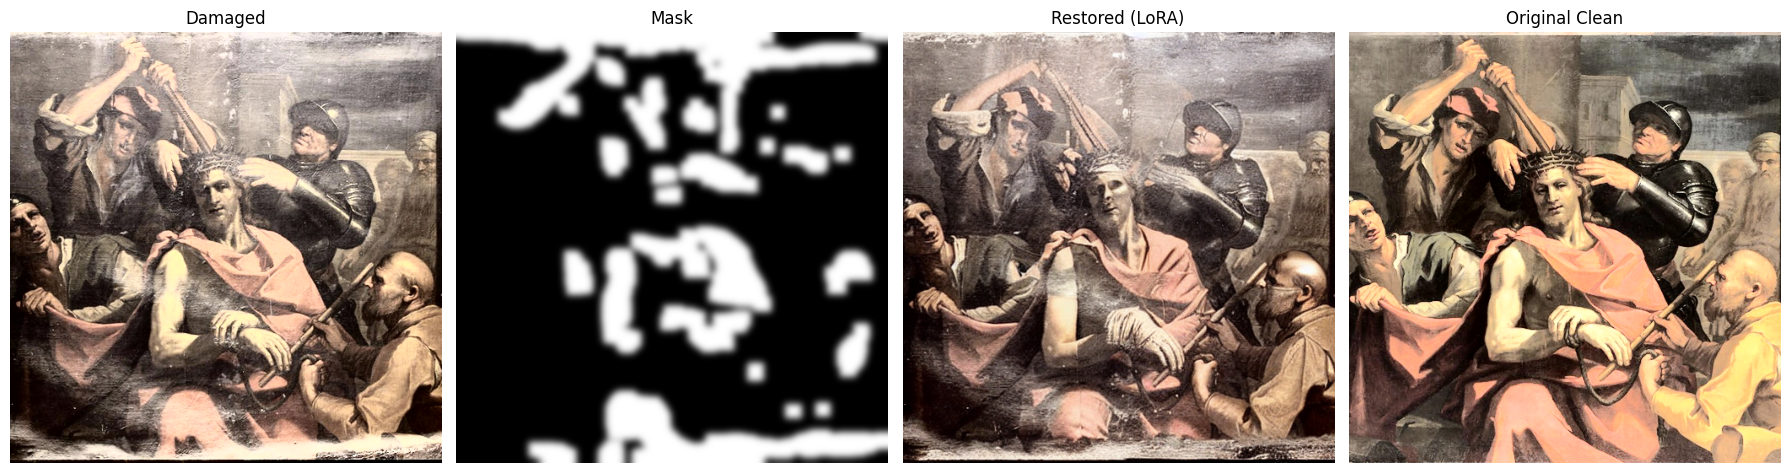

In [42]:
# Damaged → Mask → Restored → Clean
import matplotlib.pyplot as plt

# Selecting a random image
fname = random.choice(os.listdir(DAMAGED_DIR))
print("Testing on:", fname)

damaged_pil = Image.open(os.path.join(DAMAGED_DIR, fname)).convert("RGB").resize((512,512))
mask_pil    = Image.open(os.path.join(MASK_DIR, fname)).convert("L").resize((512,512))
clean_pil   = Image.open(os.path.join(CLEAN_DIR, fname)).convert("RGB").resize((512,512))


# Restoration Inference
with torch.no_grad():
    restored_pil = pipe(
        prompt="high quality realistic photo restoration, clean skin, remove cracks and damage",
        negative_prompt="blur, artifacts, distortion, oversharpen",
        image=damaged_pil,
        mask_image=mask_pil,
        num_inference_steps=60,
        guidance_scale=7.5,
        strength=0.85
    ).images[0]


# Comparison of Images
plt.figure(figsize=(18,5))

plt.subplot(1,4,1)
plt.imshow(damaged_pil)
plt.title("Damaged")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(mask_pil, cmap="gray")
plt.title("Mask")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(restored_pil)
plt.title("Restored (LoRA)")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(clean_pil)
plt.title("Original Clean")
plt.axis("off")

plt.tight_layout()
plt.show()

Testing on: 006.png


  0%|          | 0/44 [00:00<?, ?it/s]

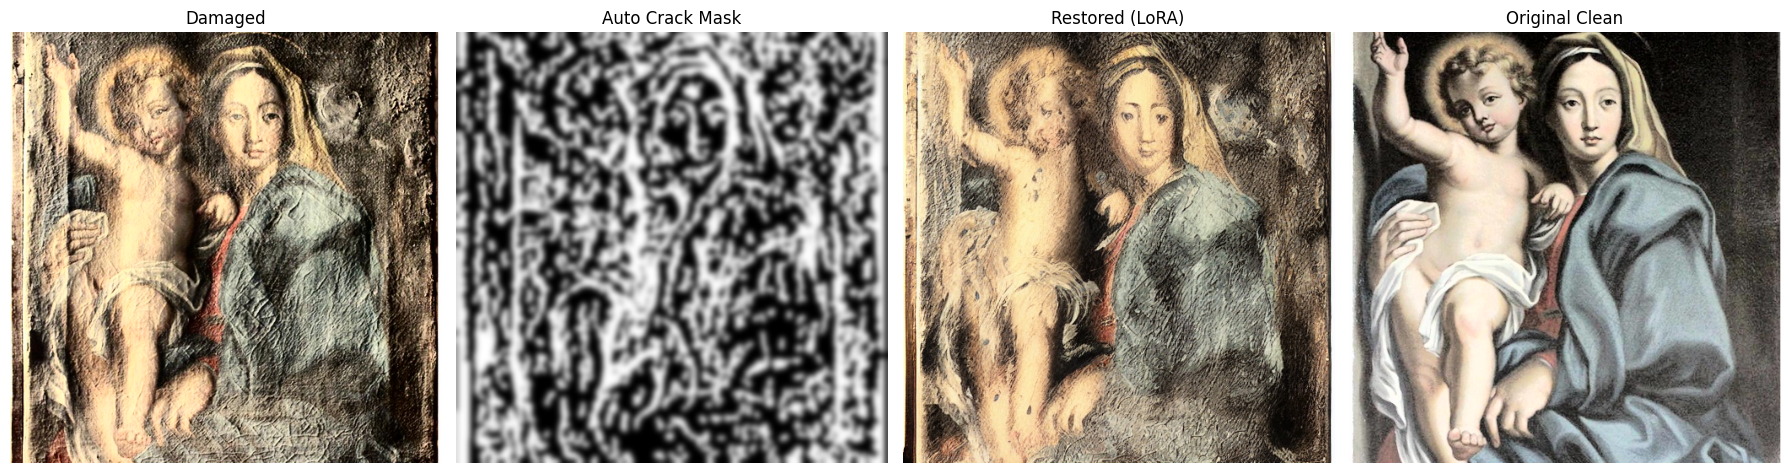

In [43]:
fname = sorted(os.listdir(DAMAGED_DIR))[5]
print("Testing on:", fname)

damaged_pil = Image.open(os.path.join(DAMAGED_DIR, fname)).convert("RGB").resize((512,512))
clean_pil   = Image.open(os.path.join(CLEAN_DIR, fname)).convert("RGB").resize((512,512))


dam_np = np.array(damaged_pil)

# 1.Grayscale
gray = cv2.cvtColor(dam_np, cv2.COLOR_RGB2GRAY)

# 2.Black-hat to extract dark cracks
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 25))
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)

# 3 Contrast stretch
blackhat = cv2.normalize(blackhat, None, 0, 255, cv2.NORM_MINMAX)

# 4.Adaptive threshold
mask_bin = cv2.adaptiveThreshold(
    blackhat,
    255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY,
    31,
    3)

# 5.Clean salt noise
kernel = np.ones((3,3), np.uint8)
mask_bin = cv2.morphologyEx(mask_bin, cv2.MORPH_OPEN, kernel, iterations=1)

# 6.Strengthen real cracks
mask_bin = cv2.dilate(mask_bin, kernel, iterations=1)

# 7.AREA FILTER
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask_bin, connectivity=8)

filtered = np.zeros_like(mask_bin)
for i in range(1, num_labels):
    area = stats[i, cv2.CC_STAT_AREA]
    if 40 < area < 25000:
        filtered[labels == i] = 255

# 8.Museum-grade feathering
mask_soft = cv2.GaussianBlur(filtered, (21,21), 0)

mask_pil = Image.fromarray(mask_soft).convert("L")


# LoRA Restoration
with torch.no_grad():
    restored_pil = pipe(
        prompt="museum-quality oil painting restoration, remove only cracks and paint damage, preserve original face and lighting",
        negative_prompt="scratches, cracks, texture artifacts, repaint, blur, identity change",
        image=damaged_pil,
        mask_image=mask_pil,
        num_inference_steps=80,
        guidance_scale=4.8,
        strength = 0.55
    ).images[0]


plt.figure(figsize=(18,5))

plt.subplot(1,4,1)
plt.imshow(damaged_pil)
plt.title("Damaged")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(mask_pil, cmap="gray")
plt.title("Auto Crack Mask")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(restored_pil)
plt.title("Restored (LoRA)")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(clean_pil)
plt.title("Original Clean")
plt.axis("off")

plt.tight_layout()
plt.show()

Mask intensity: 32.70420455932617


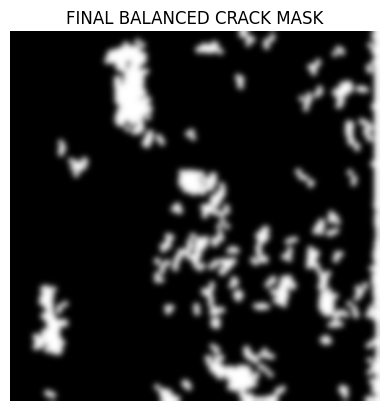

  0%|          | 0/65 [00:00<?, ?it/s]

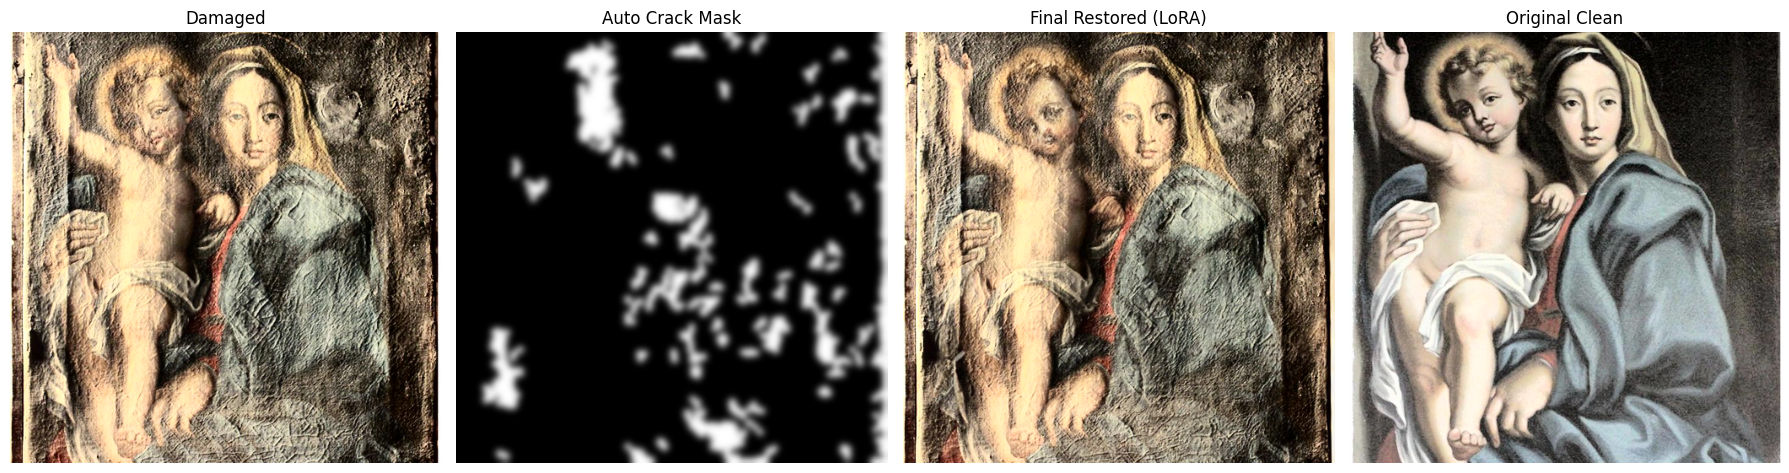

In [44]:
dam_np = np.array(damaged_pil)

lab = cv2.cvtColor(dam_np, cv2.COLOR_RGB2LAB)
l, a, b = cv2.split(lab)

hp = cv2.Laplacian(l, cv2.CV_8U, ksize=3)
hp = cv2.normalize(hp, None, 0, 255, cv2.NORM_MINMAX)

_, crack_bin = cv2.threshold(hp, 8, 255, cv2.THRESH_BINARY)

_, paint_loss = cv2.threshold(l, 200, 255, cv2.THRESH_BINARY)

raw_mask = cv2.bitwise_or(crack_bin, paint_loss)
kernel = np.ones((3,3), np.uint8)
raw_mask = cv2.morphologyEx(raw_mask, cv2.MORPH_OPEN, kernel)
raw_mask = cv2.dilate(raw_mask, kernel, iterations=2)
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(raw_mask, connectivity=8)

filtered = np.zeros_like(raw_mask)
for i in range(1, num_labels):
    area = stats[i, cv2.CC_STAT_AREA]


    if 120 < area < 6000:
        filtered[labels == i] = 255


mask_soft = cv2.GaussianBlur(filtered, (25,25), 0)
mask_pil = Image.fromarray(mask_soft).convert("L")


print("Mask intensity:", np.mean(np.array(mask_pil)))

plt.imshow(mask_pil, cmap="gray")
plt.title("FINAL BALANCED CRACK MASK")
plt.axis("off")
plt.show()


with torch.no_grad():
    restored = pipe(
        prompt="museum-quality realistic oil painting restoration, reconstruct missing paint, remove cracks only, preserve original faces and lighting",
        negative_prompt="blur, distortion, repainting, wax texture, identity change",
        image=damaged_pil,
        mask_image=mask_pil,
        num_inference_steps=80,
        guidance_scale=6.5,
        strength=0.82
    ).images[0]


rest_np  = np.array(restored).astype(np.float32)
orig_np  = np.array(damaged_pil).astype(np.float32)
mask_np  = np.array(mask_pil).astype(np.float32) / 255.0


mask_np = np.clip(mask_np * 1.35, 0, 1)

final = rest_np * mask_np[..., None] + orig_np * (1 - mask_np[..., None])
final = np.clip(final, 0, 255).astype(np.uint8)
final_pil = Image.fromarray(final)

plt.figure(figsize=(18,5))

plt.subplot(1,4,1)
plt.imshow(damaged_pil)
plt.title("Damaged")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(mask_pil, cmap="gray")
plt.title("Auto Crack Mask")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(final_pil)
plt.title("Final Restored (LoRA)")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(clean_pil)
plt.title("Original Clean")
plt.axis("off")

plt.tight_layout()
plt.show()

# **Evaluation**

In [45]:
!pip install -q scikit-image

In [46]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def compute_metrics(clean_pil, restored_pil):
    clean = np.array(clean_pil).astype(np.float32)
    restored = np.array(restored_pil).astype(np.float32)

    psnr_val = psnr(clean, restored, data_range=255)

    ssim_val = ssim(
        clean,
        restored,
        data_range=255,
        channel_axis=2
    )

    return psnr_val, ssim_val

In [47]:
NUM_SAMPLES = 50

psnr_damaged_list  = []
ssim_damaged_list  = []
psnr_restored_list = []
ssim_restored_list = []

pipe.unet.eval()
pipe.vae.eval()
pipe.text_encoder.eval()

def tensor_to_pil(t):
    if t.min() < 0:
        t = (t + 1) / 2
    t = t.squeeze().permute(1,2,0).cpu().numpy()
    t = (t * 255).clip(0,255).astype(np.uint8)
    return Image.fromarray(t)

def compute_metrics(gt_img, pred_img):
    gt   = np.array(gt_img).astype(np.float32)
    pred = np.array(pred_img).astype(np.float32)

    psnr_val = psnr(gt, pred, data_range=255)
    ssim_val = ssim(
        gt,
        pred,
        data_range=255,
        channel_axis=2
    )

    return psnr_val, ssim_val

for _ in tqdm(range(NUM_SAMPLES)):

    idx = random.randint(0, len(dataset)-1)
    sample = dataset[idx]

    clean_pil   = tensor_to_pil(sample["clean images"])
    damaged_pil = tensor_to_pil(sample["damaged images"])

    mask_np = sample["mask"].squeeze().cpu().numpy()
    mask_np = (mask_np * 255).astype(np.uint8)
    kernel = np.ones((5,5), np.uint8)
    mask_np = cv2.erode(mask_np, kernel, iterations=1)
    mask_np = cv2.GaussianBlur(mask_np, (11,11), 0)

    mask_pil = Image.fromarray(mask_np).convert("L")
    with torch.no_grad():
        restored = pipe(
            prompt="photorealistic face restoration, preserve identity, natural skin texture",
            negative_prompt="scratches, streaks, artifacts, repainting",
            image=damaged_pil,
            mask_image=mask_pil,
            num_inference_steps=40,
            guidance_scale=3.5,
            strength=0.6
        ).images[0]

    # Metrics
    p_d, s_d = compute_metrics(clean_pil, damaged_pil)
    p_r, s_r = compute_metrics(clean_pil, restored)

    psnr_damaged_list.append(p_d)
    ssim_damaged_list.append(s_d)
    psnr_restored_list.append(p_r)
    ssim_restored_list.append(s_r)

# Final Results
print("\nFINAL FAIR EVALUATION RESULTS \n")

print(f"Damaged  → Clean | PSNR: {np.mean(psnr_damaged_list):.2f} | SSIM: {np.mean(ssim_damaged_list):.4f}")
print(f"Restored → Clean | PSNR: {np.mean(psnr_restored_list):.2f} | SSIM: {np.mean(ssim_restored_list):.4f}")

print("\n TRUE IMPROVEMENT:")

print(f"PSNR Gain : {np.mean(psnr_restored_list) - np.mean(psnr_damaged_list):+.2f} dB")
print(f"SSIM Gain : {np.mean(ssim_restored_list) - np.mean(ssim_damaged_list):+.4f}")

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:05<04:28,  5.47s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 2/50 [00:10<04:22,  5.47s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

  6%|▌         | 3/50 [00:16<04:17,  5.47s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

  8%|▊         | 4/50 [00:21<04:12,  5.48s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 10%|█         | 5/50 [00:27<04:06,  5.48s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 12%|█▏        | 6/50 [00:32<04:01,  5.49s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 14%|█▍        | 7/50 [00:38<03:56,  5.50s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 16%|█▌        | 8/50 [00:43<03:50,  5.49s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 18%|█▊        | 9/50 [00:49<03:44,  5.48s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 20%|██        | 10/50 [00:54<03:38,  5.47s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 22%|██▏       | 11/50 [01:00<03:32,  5.45s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 24%|██▍       | 12/50 [01:05<03:26,  5.44s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 26%|██▌       | 13/50 [01:11<03:20,  5.43s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 28%|██▊       | 14/50 [01:16<03:15,  5.42s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 30%|███       | 15/50 [01:21<03:09,  5.42s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 32%|███▏      | 16/50 [01:27<03:04,  5.41s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 34%|███▍      | 17/50 [01:32<02:58,  5.42s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 36%|███▌      | 18/50 [01:38<02:53,  5.42s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 38%|███▊      | 19/50 [01:43<02:48,  5.44s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 40%|████      | 20/50 [01:49<02:43,  5.44s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 42%|████▏     | 21/50 [01:54<02:38,  5.46s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 44%|████▍     | 22/50 [01:59<02:33,  5.47s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 46%|████▌     | 23/50 [02:05<02:27,  5.46s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 48%|████▊     | 24/50 [02:10<02:21,  5.45s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 50%|█████     | 25/50 [02:16<02:16,  5.45s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 52%|█████▏    | 26/50 [02:21<02:10,  5.44s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 54%|█████▍    | 27/50 [02:27<02:05,  5.44s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 56%|█████▌    | 28/50 [02:32<01:59,  5.44s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 58%|█████▊    | 29/50 [02:38<01:54,  5.43s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 60%|██████    | 30/50 [02:43<01:48,  5.44s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 62%|██████▏   | 31/50 [02:48<01:43,  5.44s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 64%|██████▍   | 32/50 [02:54<01:37,  5.44s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 66%|██████▌   | 33/50 [02:59<01:32,  5.44s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 68%|██████▊   | 34/50 [03:05<01:27,  5.44s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 70%|███████   | 35/50 [03:10<01:21,  5.44s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 72%|███████▏  | 36/50 [03:16<01:16,  5.44s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 74%|███████▍  | 37/50 [03:21<01:10,  5.44s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 76%|███████▌  | 38/50 [03:27<01:05,  5.45s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 78%|███████▊  | 39/50 [03:32<01:00,  5.45s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 80%|████████  | 40/50 [03:37<00:54,  5.45s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 82%|████████▏ | 41/50 [03:43<00:49,  5.45s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 84%|████████▍ | 42/50 [03:48<00:43,  5.45s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 86%|████████▌ | 43/50 [03:54<00:38,  5.44s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 88%|████████▊ | 44/50 [03:59<00:32,  5.44s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 90%|█████████ | 45/50 [04:05<00:27,  5.44s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 92%|█████████▏| 46/50 [04:10<00:21,  5.45s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 94%|█████████▍| 47/50 [04:16<00:16,  5.45s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 96%|█████████▌| 48/50 [04:21<00:10,  5.45s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 98%|█████████▊| 49/50 [04:26<00:05,  5.44s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

100%|██████████| 50/50 [04:32<00:00,  5.45s/it]


FINAL FAIR EVALUATION RESULTS 

Damaged  → Clean | PSNR: 12.34 | SSIM: 0.2172
Restored → Clean | PSNR: 12.44 | SSIM: 0.2245

 TRUE IMPROVEMENT:
PSNR Gain : +0.11 dB
SSIM Gain : +0.0073
